## 1. Set up Environment

In [1]:
import pandas as pd
import requests
import datetime
import pyodbc
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 2. Make the ODBC Connection

In [2]:
SERVER = 'DESKTOP-FKKJE0E'
DATABASE = 'StockData'
DRIVER = 'ODBC Driver 17 for SQL Server'
USERNAME = 'sa'
PASSWORD = '39xkjrj#OY'

conn = pyodbc.connect(f'DRIVER={DRIVER};\
                        SERVER={SERVER};\
                        DATABASE={DATABASE};\
                        UID={USERNAME};PWD={PASSWORD}')
cursor = conn.cursor()     

## 3. Pull data from our SQL Table into a Pandas Dataframe

In [3]:
engine = create_engine(f"mssql+pyodbc://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}?driver={DRIVER}")
con = engine.connect()

sql = "SELECT * FROM daily_adj WHERE symbol = 'TRKA';"
df = pd.read_sql_query(sql, con)
symbol = df['symbol'][0]

## 4. Set up Function to Call Initial Data

In [4]:
# Our tables in SQL are either DATE or DATETIME which we need to distinguish to run properly. 
# ALthough I guess we could also just make every DATE into DATETIME, they just won't have the hh/mm/ss
try:
    df['date'][0].to_pydatetime
    t = 2
except AttributeError:
    t = 1

if t == 1: # DATE format
    def initial_data(price_type='adj_close'):
        while True:
            try:
                start_date = input("Please enter the Starting Date (yyyy-m-dd)")
                start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
                if len(df.loc[df['date'] > datetime.date(start_date.year, start_date.month, start_date.day)]) > 0:
                    # Note that we use > sign not >= cause there is no point if there is only 1 date for the entire range
                    while True:
                        try:
                            end_date = input("Please enter the Ending Date (yyyy-m-dd)")
                            end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
                            if len(df.loc[df['date'] < datetime.date(end_date.year, end_date.month, end_date.day)]) > 0:
                                break
                            else:
                                print("Ending date out of range")
                                continue
                        except ValueError:
                            print("Invalid date input. Try again...")
                    break
                else:
                    print("Starting date out of range")
                    continue
            except ValueError:
                print("Invalid date input. Try again...")

        dates = df.loc[(df['date'] >= datetime.date(start_date.year, start_date.month, start_date.day)) &\
                        (df['date'] <= datetime.date(end_date.year, end_date.month, end_date.day)), ['date']\
                       ].reset_index(drop=True)
        dates = dates.iloc[:, 0].tolist() 

        prices = df.loc[(df['date'] >= datetime.date(start_date.year, start_date.month, start_date.day)) &\
                        (df['date'] <= datetime.date(end_date.year, end_date.month, end_date.day)), [price_type]\
                       ].reset_index(drop=True)
        prices = prices.iloc[:, 0].tolist()
        length = len(prices)
        
        return prices, dates, length

elif t == 2: # DATETIME format
    def initial_data(price_type='close_price'):
        while True:
            try:
                start_date = input("Please enter the Starting Date (yyyy-m-dd hh:mm:ss)")
                start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
                if len(df.loc[df['date'] > datetime.datetime(start_date.year, start_date.month, start_date.day,\
                    start_date.hour, start_date.minute, start_date.second)]) > 0:
                    while True:
                        try:
                            end_date = input("Please enter the Ending Date (yyyy-m-dd hh:mm:ss)")
                            end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
                            if len(df.loc[df['date'] < datetime.datetime(end_date.year, end_date.month, end_date.day,\
                                end_date.hour, end_date.minute, end_date.second)]) > 0:
                                break
                            else:
                                print("Ending date out of range")
                                continue
                        except ValueError:
                            print("Invalid date input. Try again...")
                    break
                else:
                    print("Starting date out of range")
                    continue
            except ValueError:
                print("Invalid date input. Try again...")

        dates = df.loc[(df['date'] >= datetime.datetime(start_date.year, start_date.month, start_date.day,\
                        start_date.hour, start_date.minute, start_date.second)) &\
                        (df['date'] <= datetime.datetime(end_date.year, end_date.month, end_date.day,\
                        end_date.hour, end_date.minute, end_date.second)), ['date']\
                       ].reset_index(drop=True)
        dates = dates.iloc[:, 0].tolist()

        prices = df.loc[(df['date'] >= datetime.datetime(start_date.year, start_date.month, start_date.day,\
                        start_date.hour, start_date.minute, start_date.second)) &\
                        (df['date'] <= datetime.datetime(end_date.year, end_date.month, end_date.day,\
                        end_date.hour, end_date.minute, end_date.second)), [price_type]\
                       ].reset_index(drop=True)
        prices = prices.iloc[:, 0].tolist()
        length = len(prices)

        return prices, dates, length
else:
    print("Something is wrong with the date type")

       
# if date has hours/minutes/seconds, python will give a type timestamp for date which we can change into datetime
# using to_pydatetime()

## 5. Call the Data and Prepare/Scale

In [21]:
prices, dates, length = initial_data()
prices_array = np.array(prices)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(prices_array.reshape(-1,1))

timesteps = 60

x_train = []
y_train = []

for x in range(timesteps, len(scaled_data)):
    x_train.append(scaled_data[x-timesteps:x, 0]) # Our 2D array is [nx1] so we need to take [x, 0]
    y_train.append(scaled_data[x, 0])

# This results in x_train being a list of arrays. Each array has size=timesteps. [0 -> 59], [1 -> 60], etc.
# y_train is always ONE VALUE AHEAD of the last x_train index -> so our model can learn to predict the correct NEXT value

    
x_train, y_train = np.array(x_train), np.array(y_train) # Makes a np array of size (n, m=timesteps)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # makes x_train into 3D 

Please enter the Starting Date (yyyy-m-dd)2021-1-1
Please enter the Ending Date (yyyy-m-dd)2023-3-15


## 6. Build the Model

In [22]:
model = Sequential()

model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1))) # input_shape = (timesteps, 1) 
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next close price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25, batch_size=32)

Epoch 1/25
14/14 [==============================] - 4s 46ms/step - loss: 0.0801
Epoch 2/25
14/14 [==============================] - 1s 46ms/step - loss: 0.0399
Epoch 3/25
14/14 [==============================] - 1s 47ms/step - loss: 0.0173
Epoch 4/25
14/14 [==============================] - 1s 48ms/step - loss: 0.0095
Epoch 5/25
14/14 [==============================] - 1s 47ms/step - loss: 0.0084
Epoch 6/25
14/14 [==============================] - 1s 50ms/step - loss: 0.0061
Epoch 7/25
14/14 [==============================] - 1s 54ms/step - loss: 0.0070
Epoch 8/25
14/14 [==============================] - 1s 51ms/step - loss: 0.0070
Epoch 9/25
14/14 [==============================] - 1s 50ms/step - loss: 0.0072
Epoch 10/25
14/14 [==============================] - 1s 51ms/step - loss: 0.0074
Epoch 11/25
14/14 [==============================] - 1s 50ms/step - loss: 0.0061
Epoch 12/25
14/14 [==============================] - 1s 49ms/step - loss: 0.0067
Epoch 13/25
14/14 [==================

## 7. Get Data to Test Model Against

In [23]:
# CANNOT PICK A DATE RANGE THAT OUR MODEL WILL BE USING
prices_test, dates_test, length_test = initial_data()

total_dataset = prices + prices_test

model_inputs = total_dataset[(len(total_dataset) - length_test - timesteps):]
model_inputs = np.array(model_inputs)
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

Please enter the Starting Date (yyyy-m-dd)2023-3-16
Please enter the Ending Date (yyyy-m-dd)2023-5-10


## 8. Make Predictions on Test Data

In [24]:
x_test = []

for x in range(timesteps, len(model_inputs)):
    x_test.append(model_inputs[x-timesteps:x, 0])
    
    
# Need to make x_test.shape (n, 1) because our model takes shape (timesteps, 1)    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = np.reshape(predicted_prices, (predicted_prices.shape[0], predicted_prices.shape[1]))

# Predicted prices are scaled because we transformed them earlier so now we need to transform them back
predicted_prices = scaler.inverse_transform(predicted_prices) 

2/2 [==============================] - 0s 8ms/step


In [25]:
# Because we set 'return_sequences=True' for every single LSTM layer including the one immediately prior 'Dense' which is our
# Output Layer, 'Dense' ends up seeing a shape of (x, y, z) and so outputs (x, y, z) which has too many dimensions to be a 
# Output (Singular) y-value.

# Remove the last 'return_sequences=True' to fix the problem

print(x_test.shape)
print(type(x_test))
print(predicted_prices.shape)

(39, 60, 1)
<class 'numpy.ndarray'>
(39, 1)


## 9. Plot the Test Predictions

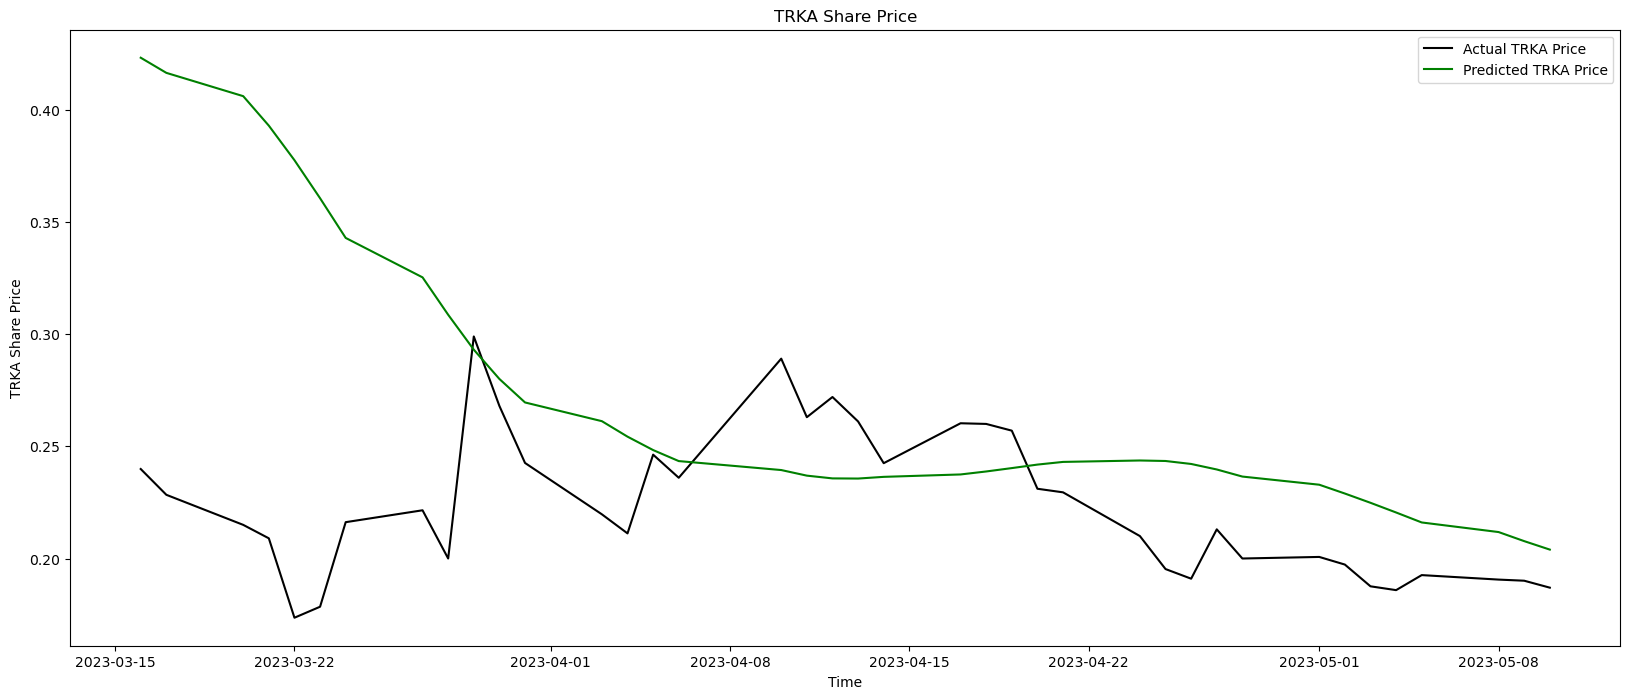

In [26]:
# prices_test is our ACTUAL prices that model ran against

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(8)
# plt.plot(dates, prices, color='blue', label=f"Full {symbol} Price")
plt.plot(dates_test, prices_test, color="black", label=f"Actual {symbol} Price")
plt.plot(dates_test, predicted_prices, color="green", label=f"Predicted {symbol} Price")
plt.title(f"{symbol} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{symbol} Share Price")
plt.legend()
plt.show()

## Predict Next Timesteps

In [27]:
# Our model takes a samples(s) with a number of timesteps of ONE feature to predict ONE singular "NEXT value"
# So if we want the most current next value, just take the very last sample of size=timesteps
# Ex. model_inputs[total_length-timesteps:total_length]

# If we want the next X values, we can simply loop the prediction by taking away the first value and adding the predicted
# in our next sample of size timesteps

def stock_prediction(future_timesteps, model_inputs):
    predictions = np.array([[]])
    
    for i in range(0, future_timesteps):
        real_prices = [model_inputs[(len(model_inputs) - timesteps):(len(model_inputs)), 0]]
        real_prices = np.array(real_prices)
        real_prices = np.reshape(real_prices, (real_prices.shape[0], real_prices.shape[1], 1))

        raw_prediction = model.predict(real_prices)
        model_inputs = np.append(model_inputs, raw_prediction, axis=0)
        predictions = np.append(predictions, scaler.inverse_transform(raw_prediction), axis=1)
    
    return predictions

In [36]:
future_timesteps = 10
predictions = stock_prediction(future_timesteps, model_inputs)

1/1 [==============================] - 0s 17ms/step


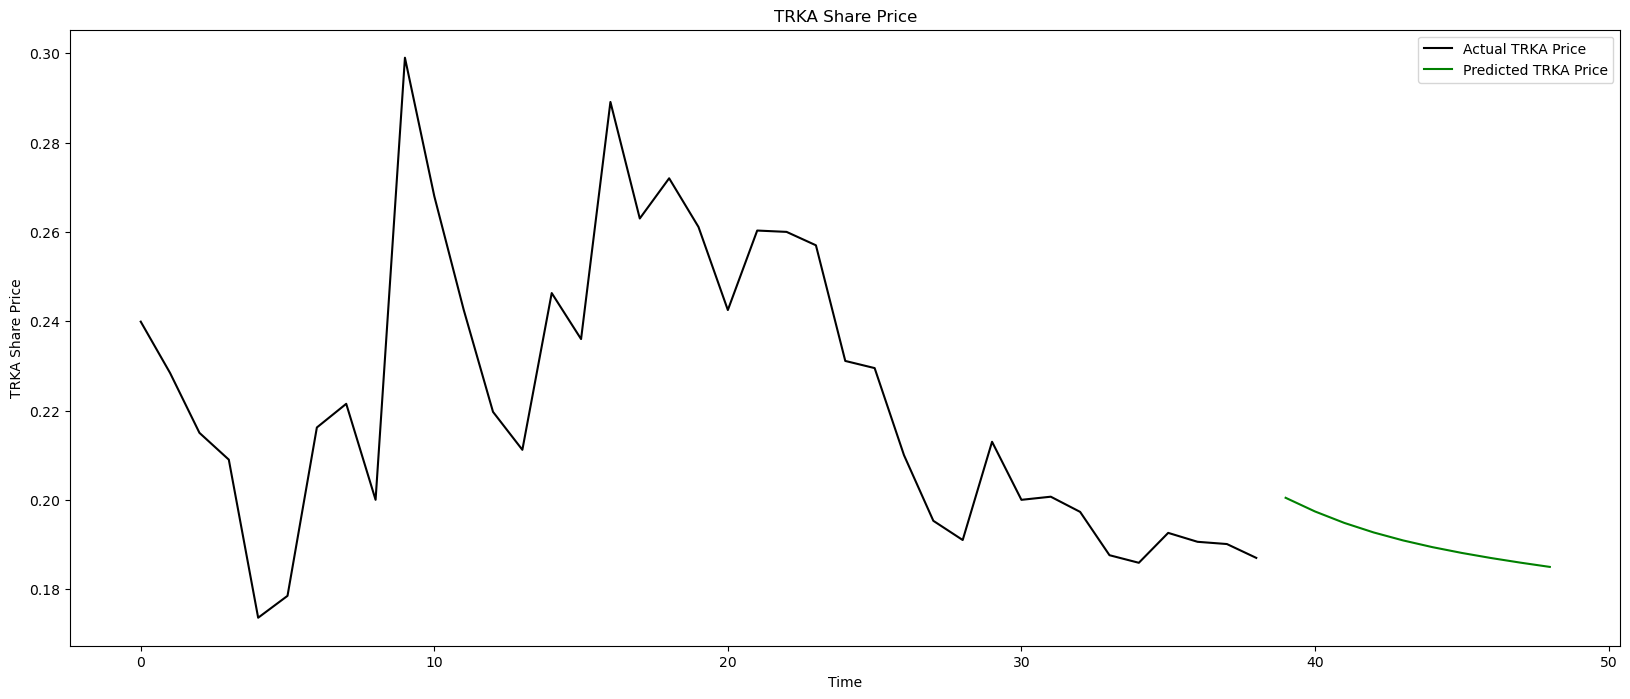

In [37]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(8)

plt.plot(np.arange(0, length_test, 1), prices_test, color="black", label=f"Actual {symbol} Price")
plt.plot(np.arange(length_test, length_test + future_timesteps, 1),\
        predictions[0], color="green", label=f"Predicted {symbol} Price")

plt.title(f"{symbol} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{symbol} Share Price")
plt.legend()
plt.show()